In [ ]:
!pip install torch  
!pip install 'transformers[torch]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Dataset from Google Dirve

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1W7mSa6SjgwhFkUsps-zr30eTc-sz-lv-

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1W7mSa6SjgwhFkUsps-zr30eTc-sz-lv-
To: /content/positivenegative-text-polarity-classification-23.zip
100% 406k/406k [00:00<00:00, 157MB/s]


In [ ]:
# Extract zip file
# ref : https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook
!apt install unzip
!unzip  'positivenegative-text-polarity-classification-23.zip' 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Archive:  positivenegative-text-polarity-classification-23.zip
  inflating: sample_submission.csv   
  inflating: test_no_answer_2022.csv  
  inflating: train_2022.csv          


In [ ]:
train_df = pd.read_csv('train_2022.csv')
test_df = pd.read_csv('test_no_answer_2022.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train_df, test_size=0.2, random_state=RANDOM_SEED)

(array([ 22., 344., 758., 115., 140., 122.,  55.,  32.,   8.,   4.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

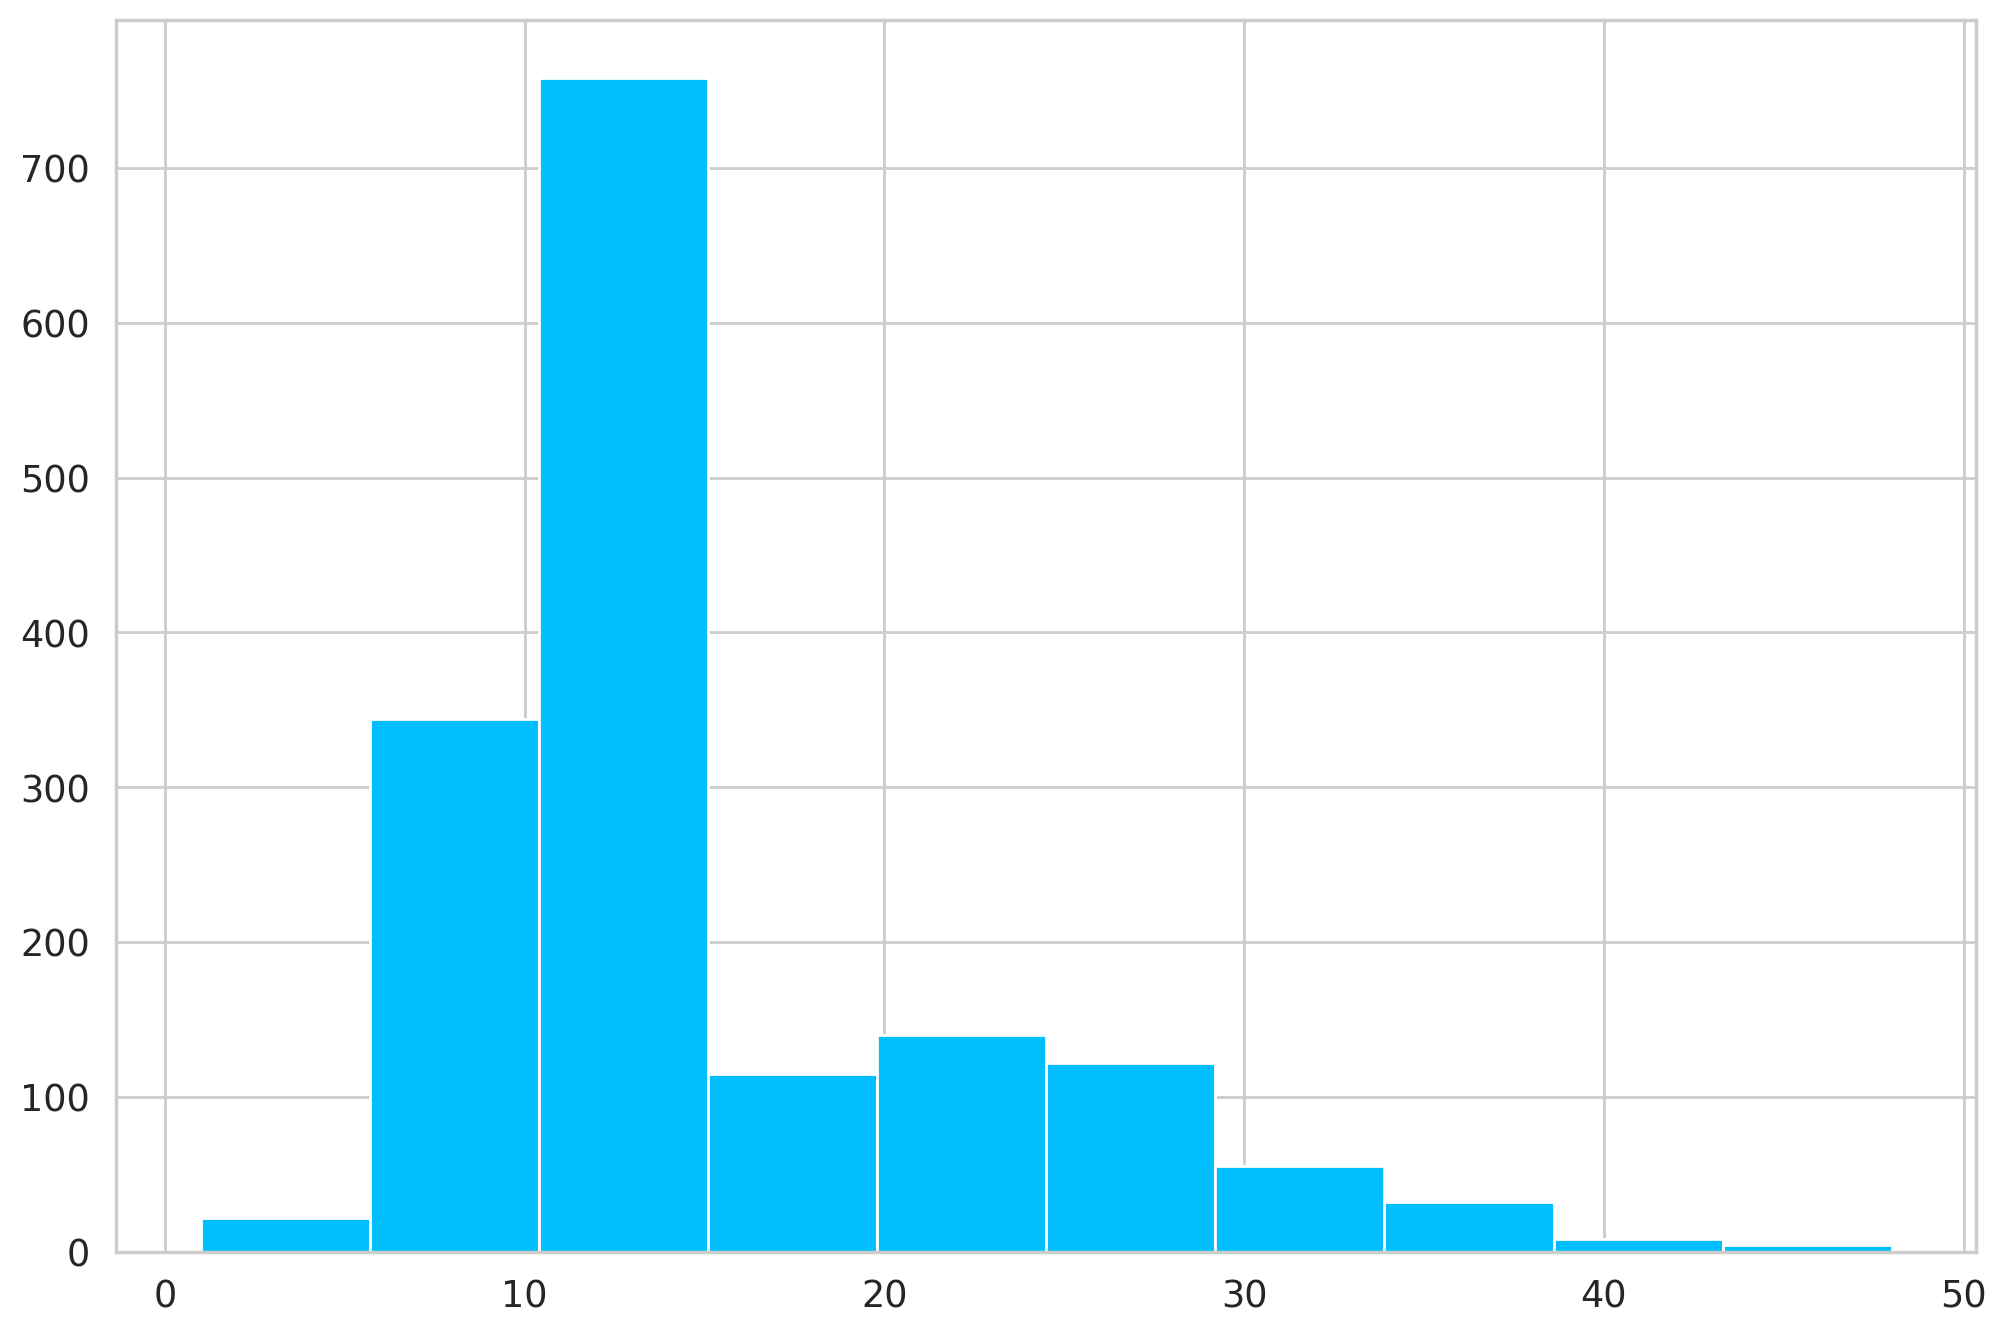

In [ ]:
# ref : https://www.geeksforgeeks.org/fine-tuning-bert-model-for-sentiment-analysis/
train_lens = [len(i.split()) for i in X_train['TEXT']]
plt.hist(train_lens)

# Initial Hyper-Paramerter

In [ ]:
from datetime import datetime
parameters = {
    'time' : str(datetime.now()).replace(" ", "_"),
    'config' : 'bert-base-uncased',
    'learning_rate' : 1e-5,
    'epochs' : 200,
    'max_len' : 75,
    'batch_size' : 16,
    'dropout' : 0.1,
    'enc_methods': 'cnn',
    'hidden_size' : 768,
    'output_size' : 128,
    'window_size' : [3,4,5,6],
    'n_class' : 2,
    'encode_layer' : 12,
    'num_filters' : 3,
}

# Create Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class SentimentDataset(Dataset):
  def __init__(self, mode, df, specify, args):
    assert ['train', 'valid', 'test']
    self.mode = mode
    if self.mode != 'test':
      self.labels = list(df['LABEL'])
    self.sentences = list(df[specify])
    self.tokenizer = AutoTokenizer.from_pretrained(args['config'])
    self.max_len = args['max_len']
  
  def __len__(self):
    return len(self.sentences)

  # transform texts to its number
  def tokenize(self, input_text):
    token_result = self.tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=self.max_len, 
      padding="max_length",
      truncation=True,
      return_token_type_ids=True
    )
    return token_result['input_ids'], token_result['attention_mask'], token_result['token_type_ids']

  def __getitem__(self, index) :
    sentence = str(self.sentences[index])
    ids, mask, token_type_ids = self.tokenize(sentence)
    
    ids = torch.tensor(ids, dtype=torch.long)
    mask = torch.tensor(mask, dtype=torch.long)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
    
    if self.mode == 'test':
      return ids, mask, token_type_ids
    else:
      return ids, mask, token_type_ids, torch.tensor(self.labels[index], dtype=torch.long)

# Load data by dataloader

In [ ]:
train_ds = SentimentDataset('train', X_train, 'TEXT', parameters)
valid_ds = SentimentDataset('valid', X_valid, 'TEXT', parameters)
test_ds = SentimentDataset('test', test_df, 'TEXT', parameters)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=parameters['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=parameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Pre-train model

## BERT

In [ ]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel

ref : https://blog.csdn.net/sunny_xsc1994/article/details/82969867

ref : https://blog.51cto.com/u_11299290/4727876 (GRU)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(args['dropout'])
        self.args = args
        total_filter = args['num_filters'] * len(args['window_size'])
        self.lstm = nn.LSTM(input_size=total_filter, hidden_size=total_filter, batch_first=True, bidirectional=False )
        self.batch_norm = nn.BatchNorm1d(total_filter)
    
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    in_channels = 1,
                    out_channels = args['num_filters'],
                    kernel_size = (h, args['hidden_size'])
                ),
                nn.ReLU(),
                nn.MaxPool2d(
                  kernel_size = (self.args['encode_layer']-h+1, 1)
                )
            )
            for h in args['window_size']
        ])
        self.fc1 = nn.Linear(in_features=total_filter, out_features=total_filter//2)
        self.fc2 = nn.Linear(in_features=total_filter//2, out_features=2)
    def forward(self, x):
        x = x.unsqueeze(1) # [bs, channel=1, seq, hidden]
        pooled_outputs = []
        for conv in self.convs:
          pooled = conv(x).permute(0, 3, 2, 1)
          pooled_outputs.append(pooled)
        out = torch.cat(pooled_outputs, dim=3) # [bs, h=1, w=1, channel=4 * 3]
        out = out.view(out.size(0), -1) # batch_size * (10 * (window_size * hidden_size))
        out = self.dropout(out)
        lstm_out,hidden = self.lstm(out)
        lstm_out = self.batch_norm(lstm_out) # batch_size * (10 * (window_size * hidden_size))
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
class BertClassifier(BertPreTrainedModel):
  def __init__(self, config, args):
    super(BertClassifier, self).__init__(config)
    self.bert = BertModel(config)
    for param in self.bert.parameters():
        param.requires_grad = False
    # self.init_weights()
    self.dropout = nn.Dropout(args['dropout'])
    self.classifier = nn.Linear(args['output_size'], 2)
    self.enc_method = args['enc_methods']
    self.encoder = Encoder(args)

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, 
              head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, 
              output_hidden_states=None, return_dict=None):
    out = self.bert(
      input_ids=input_ids, 
      attention_mask=attention_mask, 
      token_type_ids=token_type_ids, 
      position_ids=position_ids, 
      head_mask=head_mask, 
      inputs_embeds=inputs_embeds, 
      output_attentions=output_attentions, 
      output_hidden_states=output_hidden_states, 
      return_dict=return_dict
    )

    hidden_states = out.hidden_states # 13 * [bs, seq_len, hiddem]
    cls_embeddings = hidden_states[1][:, 0, :].unsqueeze(1) # [bs, 1, hidden]
    # extract [cls] vector of each layers, and concate them as input of encoder
    for i in range(2, 13):
      cls_embeddings = torch.cat((cls_embeddings, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1)
    logits = self.encoder(cls_embeddings)
    # logits = self.dropout(x)
    # logits = self.classifier(x)

    if labels is not None:
      loss_fct = torch.nn.CrossEntropyLoss()
      loss = loss_fct(logits, labels)
      return logits, loss
    return logits

In [ ]:
data = next(iter(train_loader))
ids, masks, token_type_ids, labels = [t.to(device) for t in data]

In [ ]:
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
output = model(
    input_ids = ids,
    attention_mask = masks,
    token_type_ids = token_type_ids,
    output_hidden_states=True,
    labels = labels
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertClassifier: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertClassifier were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['encoder.conv

In [ ]:
output

(tensor([[-8.0074e-04,  6.3396e-04],
         [-1.1553e-03,  9.3418e-04],
         [-4.1315e-04,  4.3794e-04],
         [-6.2515e-04,  5.6933e-04],
         [-8.2167e-04,  6.6844e-04],
         [-5.0222e-04,  3.3211e-04],
         [-7.5568e-04,  5.3423e-04],
         [-1.5257e-04,  2.9335e-04],
         [-7.2954e-04,  5.3062e-04],
         [ 1.2214e-04,  3.6312e-04],
         [-4.1088e-04,  5.9866e-04],
         [-7.7621e-04, -1.2828e-05],
         [-1.3296e-03,  3.0947e-04],
         [-7.0227e-04,  2.1331e-04],
         [-4.6277e-04,  3.7237e-04],
         [-1.9910e-04,  9.5712e-04]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>))

# Initail Model

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch.optim as optim

ref : https://www.emperinter.info/2020/08/05/change-leaning-rate-by-reducelronplateau-in-pytorch/

In [ ]:
transformers.logging.set_verbosity_error() # close the warning message
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)
lr_sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# Define evaluate model

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
# get predict result
def get_pred(logits):
  _, preds = torch.max(logits, dim=1)
  return preds
# calculate confusion metrics
def cal_metrics(pred, ans):
  ans = ans.detach().cpu().numpy()
  pred = pred.detach().cpu().numpy()

  acc = accuracy_score(ans, pred)
  f1 = f1_score(ans, pred,  zero_division=0)
  recall = recall_score(ans, pred,  zero_division=0)
  precision = precision_score(ans, pred,  zero_division=0)
  return acc, f1, recall, precision

In [ ]:
# evaluate dataloader
def evaluate(model, data_loader, device):
  val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
  step_count = 0

  model.eval()
  with torch.no_grad():
    for data in data_loader:
      ids, masks, token_type_ids, labels = [t.to(device) for t in data]

      logits, loss = model(input_ids = ids, 
              token_type_ids = token_type_ids, 
              attention_mask = masks,
              output_hidden_states=True,
              labels = labels)
      acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
      
      val_loss += loss.item()
      val_acc += acc
      val_f1 += f1
      val_rec += rec
      val_prec += prec
      step_count+=1

    val_loss = val_loss / step_count
    val_acc = val_acc / step_count
    val_f1 = val_f1 / step_count
    val_rec = val_rec / step_count
    val_prec = val_prec / step_count
      
  return val_loss, val_acc, val_f1, val_rec, val_prec

In [ ]:
# save model to path
def save_checkpoint(save_path, model):
  if save_path == None:
      return
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):    
  if load_path==None:
      return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  
  model.load_state_dict(state_dict)
  return model

In [ ]:
# Start training
import time
metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
mode = ['train_', 'val_']
record = {s+m :[] for s in mode for m in metrics}
# save best model
highest_acc = 0.0

for epoch in range(parameters["epochs"]):

    st_time = time.time()
    train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0

    model.train()
    for data in train_loader:
        ids, masks, token_type_ids, labels = [t.to(device) for t in data]
        logits, loss = model(
          input_ids = ids,
          token_type_ids = token_type_ids,
          attention_mask = masks,
           output_hidden_states=True,
          labels = labels,
        )
        acc, f1, rec, prec = cal_metrics(get_pred(logits), labels)
        train_loss += loss.item()
        train_acc += acc
        train_f1 += f1
        train_rec += rec
        train_prec += prec

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step_count += 1
    
    # evaluate the model performace on val data after finishing an epoch training 
    val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, valid_loader, device)

    train_loss = train_loss / step_count
    train_acc = train_acc / step_count
    train_f1 = train_f1 / step_count
    train_rec = train_rec / step_count
    train_prec = train_prec / step_count
    # lr_sheduler.step(val_loss)
    
    print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
    print('         loss     acc     f1      rec    prec')
    print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
    print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

    # record training metrics of each training epoch
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['train_f1'].append(train_f1)
    record['train_rec'].append(train_rec)
    record['train_prec'].append(train_prec)

    record['val_loss'].append(val_loss)
    record['val_acc'].append(val_acc)
    record['val_f1'].append(val_f1)
    record['val_rec'].append(val_rec)
    record['val_prec'].append(val_prec)

    # save best accuracy
    the_current_acc = val_acc
    if the_current_acc >= highest_acc:
      highest_acc = the_current_acc
      save_checkpoint('./bert.pt' , model)

[epoch 1] cost time: 10.1630 s
         loss     acc     f1      rec    prec
train | 0.6932, 0.4931, 0.6527, 1.0000, 0.4931
val  | 0.6931, 0.5275, 0.6860, 1.0000, 0.5275

Model saved to ==> ./bert.pt
[epoch 2] cost time: 9.0095 s
         loss     acc     f1      rec    prec
train | 0.6931, 0.4931, 0.6507, 1.0000, 0.4931
val  | 0.6931, 0.5275, 0.6784, 1.0000, 0.5275

Model saved to ==> ./bert.pt
[epoch 3] cost time: 9.1924 s
         loss     acc     f1      rec    prec
train | 0.6931, 0.5125, 0.6559, 0.9755, 0.5059
val  | 0.6930, 0.5750, 0.6883, 0.9269, 0.5587

Model saved to ==> ./bert.pt
[epoch 4] cost time: 9.2358 s
         loss     acc     f1      rec    prec
train | 0.6930, 0.5487, 0.6598, 0.9245, 0.5317
val  | 0.6930, 0.6425, 0.6755, 0.7460, 0.6340

Model saved to ==> ./bert.pt
[epoch 5] cost time: 9.2757 s
         loss     acc     f1      rec    prec
train | 0.6930, 0.5956, 0.6447, 0.7874, 0.5788
val  | 0.6929, 0.6575, 0.6974, 0.7711, 0.6541

Model saved to ==> ./bert.pt
[epo

In [ ]:
# draw learning curve
import matplotlib.pyplot as plt
EPOCHS = parameters['epochs']
def draw_pics(record, name, img_save=False, show=False):
    x_ticks = range(1, EPOCHS+1)
    
    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue', 
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink', 
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)
    x_ticks = range(0, EPOCHS+1, 50)
    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')
    
    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()
        
    plt.close()

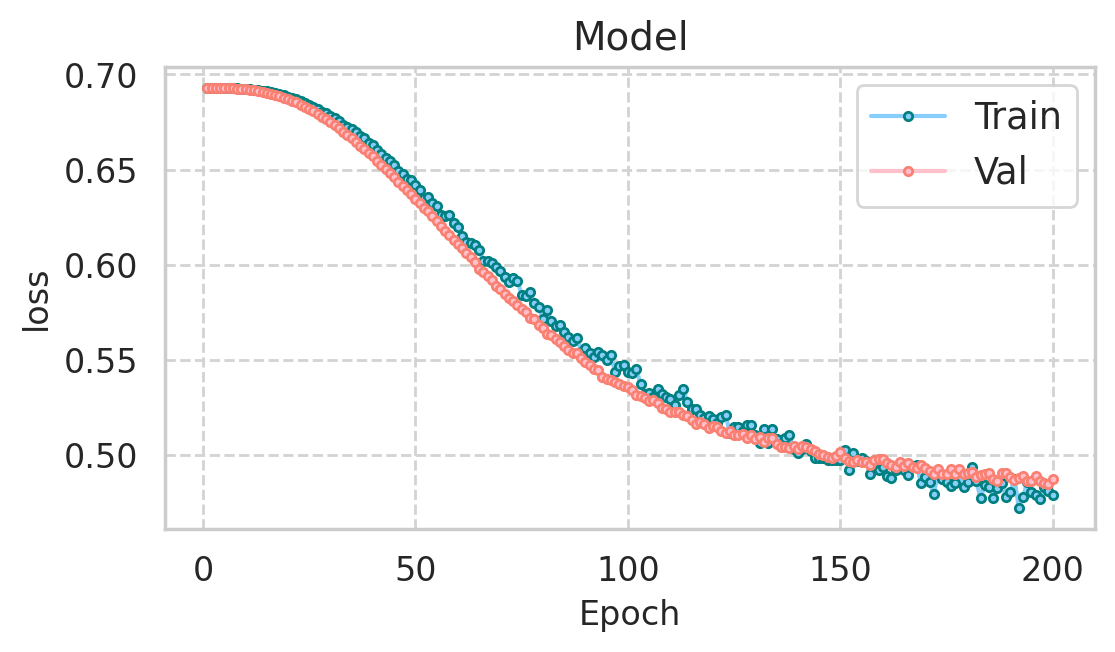

In [ ]:
draw_pics(record, 'loss', img_save=False, show=True)

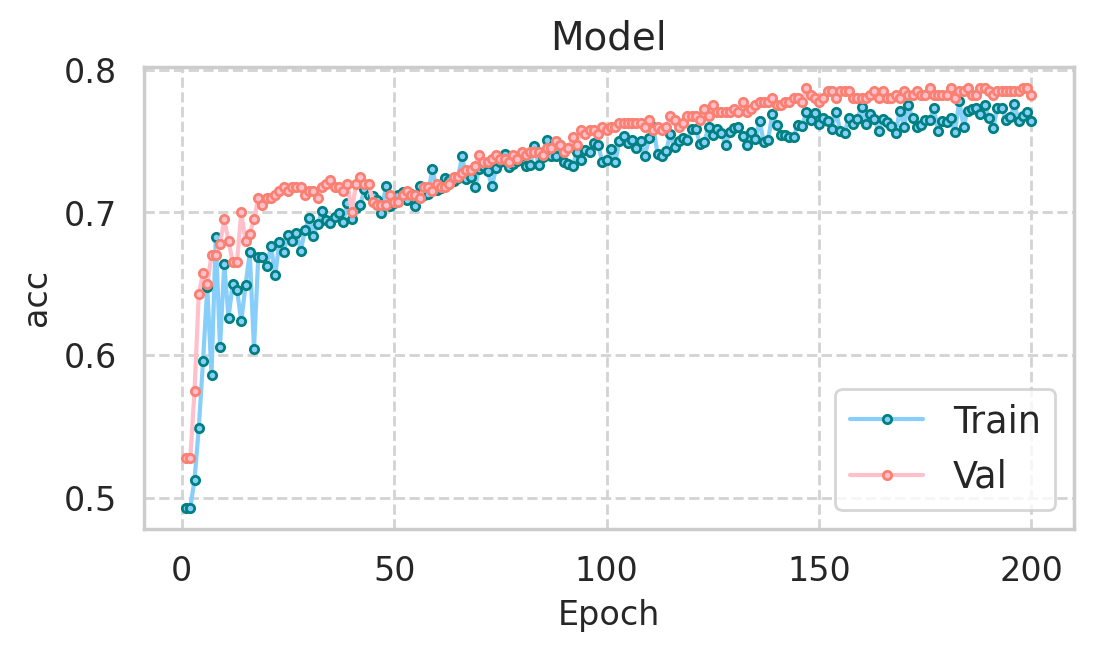

In [ ]:
draw_pics(record, 'acc', img_save=False, show=True)

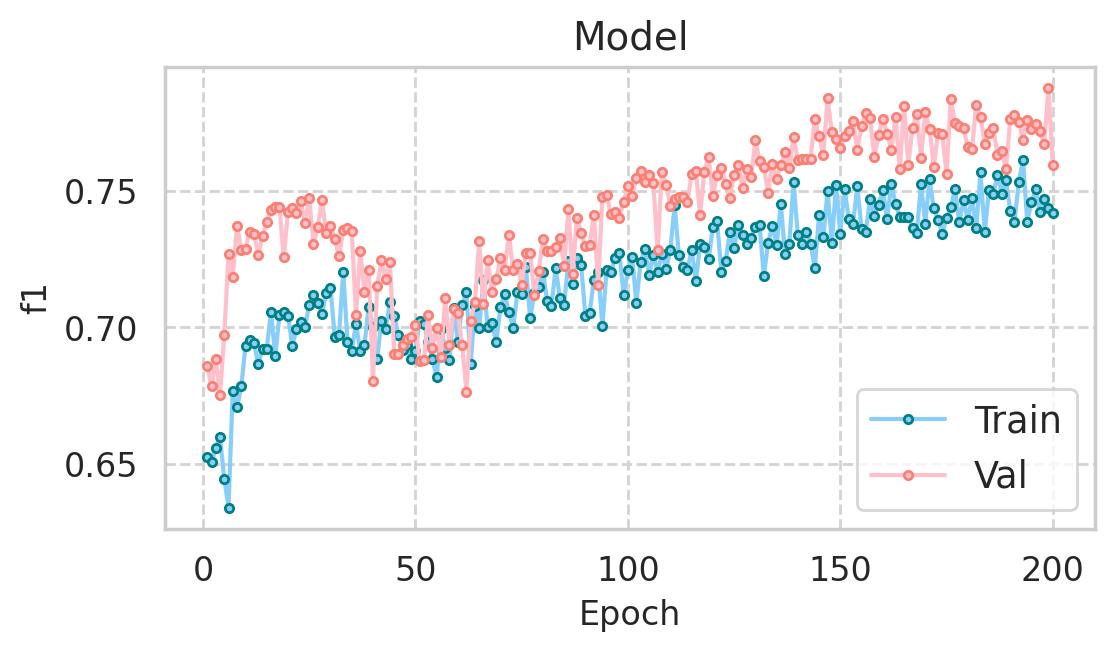

In [ ]:
draw_pics(record, 'f1', img_save=False, show=True)

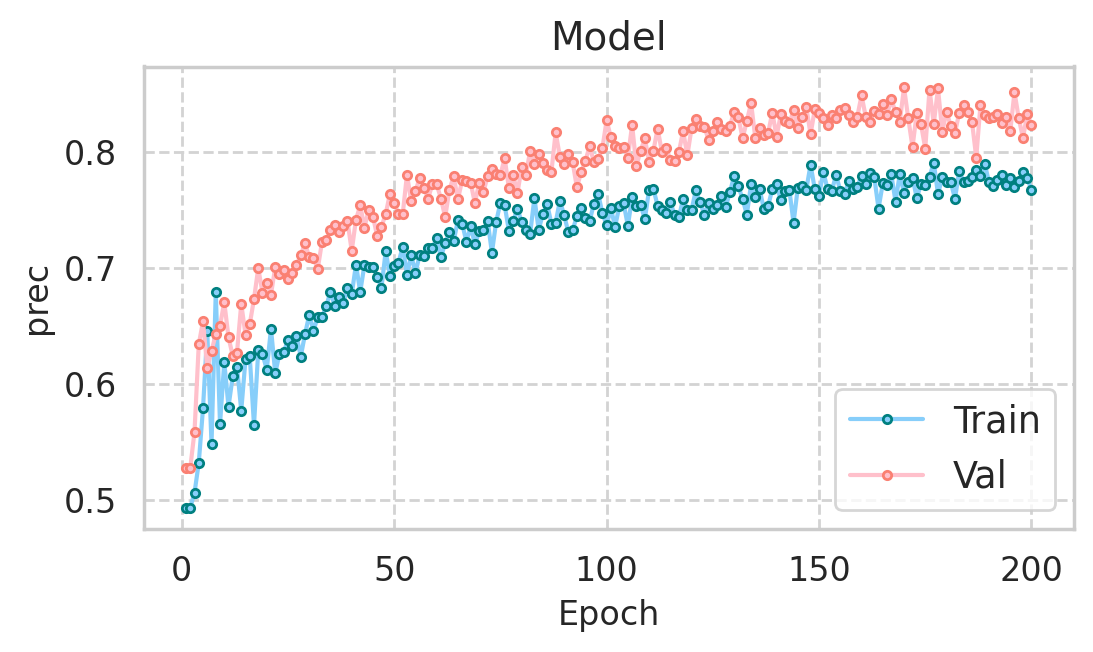

In [ ]:
draw_pics(record, 'prec', img_save=False, show=True)

In [ ]:
# save model
# model = save_checkpoint('./bert.pt' , model)
model = load_checkpoint('./bert.pt', model, device) 

Model loaded from <== ./bert.pt


In [ ]:
def Softmax(x):
  return torch.exp(x) / torch.exp(x).sum()
# label to class
def label2class(label):
  l2c = {0:'negative', 1:'positive'}
  return l2c[label]

In [ ]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_preds = []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
        input_ids, attention_mask, \
        token_type_ids = [t.to(device) for t in data]

        # forward pass
        logits = model(input_ids, attention_mask, token_type_ids, output_hidden_states=True)
        total_preds.append(get_pred(logits).item())
    
  return total_preds

In [ ]:
total_preds = predict(test_loader, model)

In [ ]:
len(total_preds)

In [ ]:
submission_df = pd.DataFrame()
submission_df['row_id'] = test_df['row_id']
submission_df['LABEL'] = total_preds

In [ ]:
submission_df

In [ ]:
submission_df.to_csv('submission_.csv', index=False)

In [ ]:
submission_df['LABEL'].value_counts()

In [ ]:
submission_df['LABEL'].value_counts()

In [ ]:
print('         loss     acc     f1      rec    prec')
print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))